# NYC Rodent Sightings - 311 2018-2023

#### _Overview_ 
This notebook parses the 311 rodent sighting complaints for the 2018 to 2023 time span, and aggregates the sightings to the census block group spatial unit. One-hot encoding is used to create a boolean column per variables to sum the total count of sightings. 

- **Location Type** is simplified to a new columns called 'loc_type' with the following classifications: residential, residential-mixed, commercial, outdoor, vacant, and other. In the final census block dataset these are prefixed with `l_` indicating location.

- **Temporal** derivatives are calculated including year, month, day of week, and a simple time range. In the final census block dataset these are prefixed with `m_`, `d_`, and `t_` indicating month, day of week and time, respectively.

Caveats: 

    The final dataset has duplicate polygons: 1 per year 
    Duplicate reports on the same day from the same address are dropped. 


<u>Citations<u>
    
    MLA Format:
    NYC OpenData, Rat Sightings, https://data.cityofnewyork.us/Social-Services/Rat-Sightings/3q43-55fe.

    LaTeX Format:
    \bibitem{RatSightings}
    NYC OpenData. \emph{Rat Sightings}. https://data.cityofnewyork.us/Social-Services/Rat-Sightings/3q43-55fe.



In [1]:
from datetime import datetime, timedelta
import geopandas as gpd
import json
import pandas as pd
import mapclassify
import matplotlib.pyplot as plt
import numpy as np
import os
import requests
from io import StringIO
import warnings

warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option("display.max_rows", None)
np.set_printoptions(threshold=np.inf)

In [2]:
# 311 Rat Sightings
params_sightings = {
    '$where': "created_date between '2018-01-01T00:00:00' and '2023-12-31T23:59:59'",
    '$limit': 500000  # Limit the number of records, adjust as needed
}
sightings_url = 'https://data.cityofnewyork.us/resource/3q43-55fe.geojson'
# https://data.cityofnewyork.us/Social-Services/Rat-Sightings/3q43-55fe

In [3]:
sightings_response = requests.get(sightings_url, params=params_sightings)
sightings_json = sightings_response.json()
sightings_gdf = gpd.GeoDataFrame.from_features(sightings_json['features'])
print(len(sightings_gdf))
sightings_gdf.head()

108119


geometry location_state facility_type  \
0  POINT (-73.94675 40.81323)                         None   
1  POINT (-73.94574 40.81281)                         None   
2  POINT (-73.94159 40.65996)                         None   
3  POINT (-73.86086 40.82469)                         None   
4  POINT (-73.94091 40.83649)                         None   

          intersection_street_2      city location_zip park_borough  \
0  FREDERICK DOUGLASS BOULEVARD  NEW YORK                 MANHATTAN   
1  FREDERICK DOUGLASS BOULEVARD  NEW YORK                 MANHATTAN   
2                 ALBANY AVENUE  BROOKLYN                  BROOKLYN   
3            BRUCKNER BOULEVARD     BRONX                     BRONX   
4                      BROADWAY  NEW YORK                 MANHATTAN   

             latitude road_ramp             created_date  \
0   40.81323222853849      None  2023-04-12T00:16:26.000   
1   40.81281181632886      None  2023-04-12T00:15:03.000   
2  40.659962743112466      None  2023-04-12T00:13:05.000   
3   40.82469388912986      None  2023-04-11T23:01:20.000   
4  40.836485367426576      None  2023-04-11T22:41:59.000   

  y_coordinate_state_plane_ agency park_facility_name location_address  \
0                    235564  DOHMH        Unspecified                    
1                    235411  DOHMH        Unspecified                    
2                    179724  DOHMH        Unspecified                    
3                    239766  DOHMH        Unspecified                    
4                    244037  DOHMH        Unspecified                    

                               agency_name    descriptor location_city  \
0  Department of Health and Mental Hygiene  Rat Sighting                 
1  Department of Health and Mental Hygiene  Rat Sighting                 
2  Department of Health and Mental Hygiene  Rat Sighting                 
3  Department of Health and Mental Hygiene  Rat Sighting                 
4  Department of Health and Mental Hygiene  Rat Sighting                 

                 cross_street_2 bridge_highway_direction           longitude  \
0  FREDERICK DOUGLASS BOULEVARD                     None  -73.94674683872422   
1  FREDERICK DOUGLASS BOULEVARD                     None  -73.94573926927536   
2                 ALBANY AVENUE                     None  -73.94159251731416   
3            BRUCKNER BOULEVARD                     None  -73.86085883210954   
4                      BROADWAY                     None  -73.94090992546624   

  bridge_highway_segment       street_name      incident_address address_type  \
0                   None  WEST  131 STREET  230 WEST  131 STREET      ADDRESS   
1                   None  WEST  131 STREET  200 WEST  131 STREET      ADDRESS   
2                   None      RUTLAND ROAD      575 RUTLAND ROAD      ADDRESS   
3                   None  UNDERHILL AVENUE  950 UNDERHILL AVENUE      ADDRESS   
4                   None  WEST  162 STREET  533 WEST  162 STREET      ADDRESS   

  incident_zip unique_key complaint_type       status bridge_highway_name  \
0        10027   57283710         Rodent  In Progress                None   
1        10027   57283704         Rodent  In Progress                None   
2        11203   57282866         Rodent  In Progress                None   
3        10473   57289493         Rodent  In Progress                None   
4        10032   57289811         Rodent  In Progress                None   

             location_type x_coordinate_state_plane_ due_date  \
0  3+ Family Apt. Building                    998991     None   
1  3+ Family Apt. Building                    999270     None   
2    Other (Explain Below)                   1000455     None   
3  3+ Family Apt. Building                   1022759     None   
4  3+ Family Apt. Building                   1000601     None   

  taxi_company_borough taxi_pick_up_location community_board  \
0                 None                  None    10 MANHATTAN   
1                 No

<AxesSubplot:>

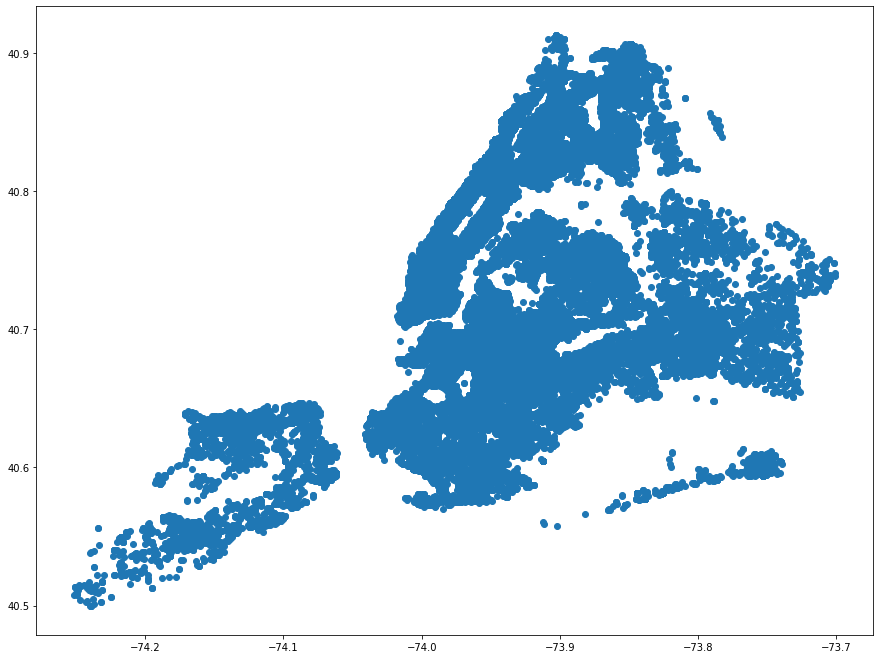

In [4]:
sightings_gdf.plot(figsize=(15,15))

# EDA on 311 Rodent sightings

Fields of interest:

    created_date
    location_type
    
Fields checked (but do not seem relevant):

    facility_type - empty
    location_state - empty
    agency - ALL DOHMH
    park_facility_name - ALL Unspecified
    agency_name - ALL Department of Health and Mental Hygiene
    descriptor - all Rat Sighting
    complaint_type - all Rodent
    status - 7% in progress. doesn't seem necessary to include
    

### Location Type explore

In [5]:
sightings_gdf.location_type.value_counts()

3+ Family Apt. Building          45630
1-2 Family Dwelling              20110
Other (Explain Below)            16989
Commercial Building               6349
3+ Family Mixed Use Building      6102
Construction Site                 2490
Vacant Lot                        2055
1-2 Family Mixed Use Building     1767
Vacant Building                   1545
Parking Lot/Garage                1287
Catch Basin/Sewer                  997
3+ Family Apartment Building       658
Street Area                        434
Public Garden                      375
Residential Building               215
School/Pre-School                  177
Government Building                170
Office Building                    114
Day Care/Nursery                    88
Apartment                           82
Other                               76
Single Room Occupancy (SRO)         75
Residence                           72
Hospital                            60
Public Stairs                       57
Building (Non-Residential

In [6]:
# Create a function to simplify location type

def simplify_location_type(location_type):
    loc_type = ""
    
    # Residential
    if location_type in ('Residential Building',
                         'Residential Property',
                         'Residence',
                         'Apartment',
                         'Private House',
                         '3+ Family Apt. Building', 
                         '3+ Family Apt',
                         '3+ Family Apt.',
                         '3+ Family Apartment Building',
                         '3+Family Apt.',
                         '1-3 Family Dwelling',
                         '1-2 FamilyDwelling',
                         '1-2 Family Dwelling'):
        loc_type = "Residential"
        
    # Residential - Mixed Use
    if location_type in ('3+ Family Mixed Use Building',
                         '1-3 Family Mixed Use Building',
                         '1-2 Family Mixed Use Building',
                         'Single Room Occupancy (SRO)'):
        loc_type = "Residential-Mixed"
    
    # Commercial/Public Facility
    if location_type in ('Commercial Building',
                         'Commercial Property',
                         'Retail Store',
                         'Grocery Store',
                         'Store',
                         'Restaurant',
                         'Restaurant/Bar/Deli/Bakery',
                         'Building (Non-Residential)',
                         'Day Care/Nursery',
                         'Office Building',
                         'Government Building',
                         'Hospital',
                         'Summer Camp',
                         'Cafeteria - Public School',
                         'School',
                         'School/Pre-School'):
        loc_type = "Commercial"

    # Public Outdoor
    if location_type in ('Street Area',
                         'Street Fair Vendor',
                         'Ground',
                         'Beach',
                         'Public Garden',
                         'Catch Basin/Sewer',
                         'Public Stairs'):
        loc_type = "Outdoor"
        
    # Buildings - Vacant
    if location_type in ('Construction Site',
                         'Vacant Lot',
                         'Vacant Lot/Property',
                         'Abandoned Building',
                         'Vacant Building',
                         'Parking Lot/Garage'):
        loc_type = "Vacant_Space"    
    
    # Other
    if location_type in ('Other (Explain Below)','N/A','Other','None','Catering Service',None):
        loc_type = "Other"      
    
    if loc_type == "":
        print(location_type)
    
    return loc_type

       
sightings_gdf['loc_type'] = sightings_gdf.apply(lambda row: simplify_location_type(row['location_type']), axis=1)
                      
sightings_gdf.loc_type.value_counts()


Residential          66805
Other                17078
Residential-Mixed     7947
Vacant_Space          7395
Commercial            7021
Outdoor               1873
Name: loc_type, dtype: int64

### Time of Day explore

In [7]:
# Create new column per range of hours

# morning (12am- 8am)
# midday(8am-4pm)
# Evening (4pm-12am)

def create_time_range(hour_of_day):
    if 0 < hour_of_day <= 6:
        return "Morning"
    elif 8 < hour_of_day <= 16:
        return "Midday"
    else: 
        return "Evening"

In [8]:
def create_date_cols(df):
    df['created_date'] = pd.to_datetime(df['created_date'])

    # Create new columns for month, day of the week, and hour of the day
    df['year'] = df['created_date'].dt.strftime('%Y')  # Year as a string
    df['month'] = df['created_date'].dt.strftime('%B')  # Month as a string
    df['day_of_week'] = df['created_date'].dt.strftime('%A')  # Day of the week as a string
    df['hour_of_day'] = df['created_date'].dt.hour  # Hour of the day as an int
    df['time_range'] = df.apply(lambda row: create_time_range(row['hour_of_day']), axis=1)
    return df

sightings_gdf = create_date_cols(sightings_gdf)
sightings_gdf.time_range.value_counts()

Evening    57535
Midday     44315
Morning     6269
Name: time_range, dtype: int64

### Combine loc_type and hour of day

Do we want to add this in?

In [9]:
sightings_gdf['loc_type_per_time'] = sightings_gdf['loc_type'] + '_' + sightings_gdf['time_range']
sightings_gdf.loc_type_per_time.value_counts()

Residential_Evening          35621
Residential_Midday           27456
Other_Evening                 8779
Other_Midday                  7265
Vacant_Space_Evening          4249
Residential-Mixed_Evening     4230
Residential_Morning           3728
Commercial_Evening            3728
Residential-Mixed_Midday      3246
Vacant_Space_Midday           2776
Commercial_Midday             2744
Other_Morning                 1034
Outdoor_Evening                928
Outdoor_Midday                 828
Commercial_Morning             549
Residential-Mixed_Morning      471
Vacant_Space_Morning           370
Outdoor_Morning                117
Name: loc_type_per_time, dtype: int64

In [10]:
sightings_gdf['loc_type_per_dow'] = sightings_gdf['loc_type'] + '_' + sightings_gdf['day_of_week']
sightings_gdf.loc_type_per_dow.value_counts()

Residential_Tuesday            11307
Residential_Monday             11279
Residential_Wednesday          10711
Residential_Thursday           10524
Residential_Friday              9339
Residential_Sunday              6907
Residential_Saturday            6738
Other_Wednesday                 2936
Other_Monday                    2812
Other_Thursday                  2797
Other_Tuesday                   2765
Other_Friday                    2347
Other_Sunday                    1741
Other_Saturday                  1680
Residential-Mixed_Monday        1356
Residential-Mixed_Tuesday       1340
Residential-Mixed_Wednesday     1330
Residential-Mixed_Thursday      1261
Vacant_Space_Monday             1260
Vacant_Space_Tuesday            1183
Commercial_Tuesday              1162
Vacant_Space_Wednesday          1158
Vacant_Space_Thursday           1149
Commercial_Monday               1132
Residential-Mixed_Friday        1124
Commercial_Wednesday            1116
Vacant_Space_Friday             1086
C

In [11]:
# Drop duplicates 
print(len(sightings_gdf))
sightings_gdf = sightings_gdf.drop_duplicates(subset=['incident_address','loc_type','year','month','day_of_week','time_range'], keep='first')
print(len(sightings_gdf))

# Summarize per Census Block Group

This geography seems very granular. Let's see how it works for our data

In [12]:
parent_dir = os.path.abspath('..')  # get the absolute path of the parent directory
file_path = os.path.join(parent_dir, 'Data', 'nyc_bgrp.geojson')  # construct the file path
cb_gdf = gpd.read_file(file_path)  # load the GeoJSON file into a GeoDataFrame

In [13]:
cb_gdf.head(2)

spatial_id                         name  %OfOwnerOccupiedHousing  \
0  360050001000  BG0001000, Bronx County, NY                      0.0   
1  360050001001  BG0001001, Bronx County, NY                      0.0   

   %OfRenterOccupiedHousing  MedianHouseholdIncome  TotalPopulation  \
0                       0.0                    NaN              0.0   
1                       0.0                    NaN           6472.0   

                                            geometry  
0  MULTIPOLYGON (((-73.89679 40.79616, -73.89681 ...  
1  POLYGON ((-73.89076 40.79782, -73.89076 40.797...

<AxesSubplot:>

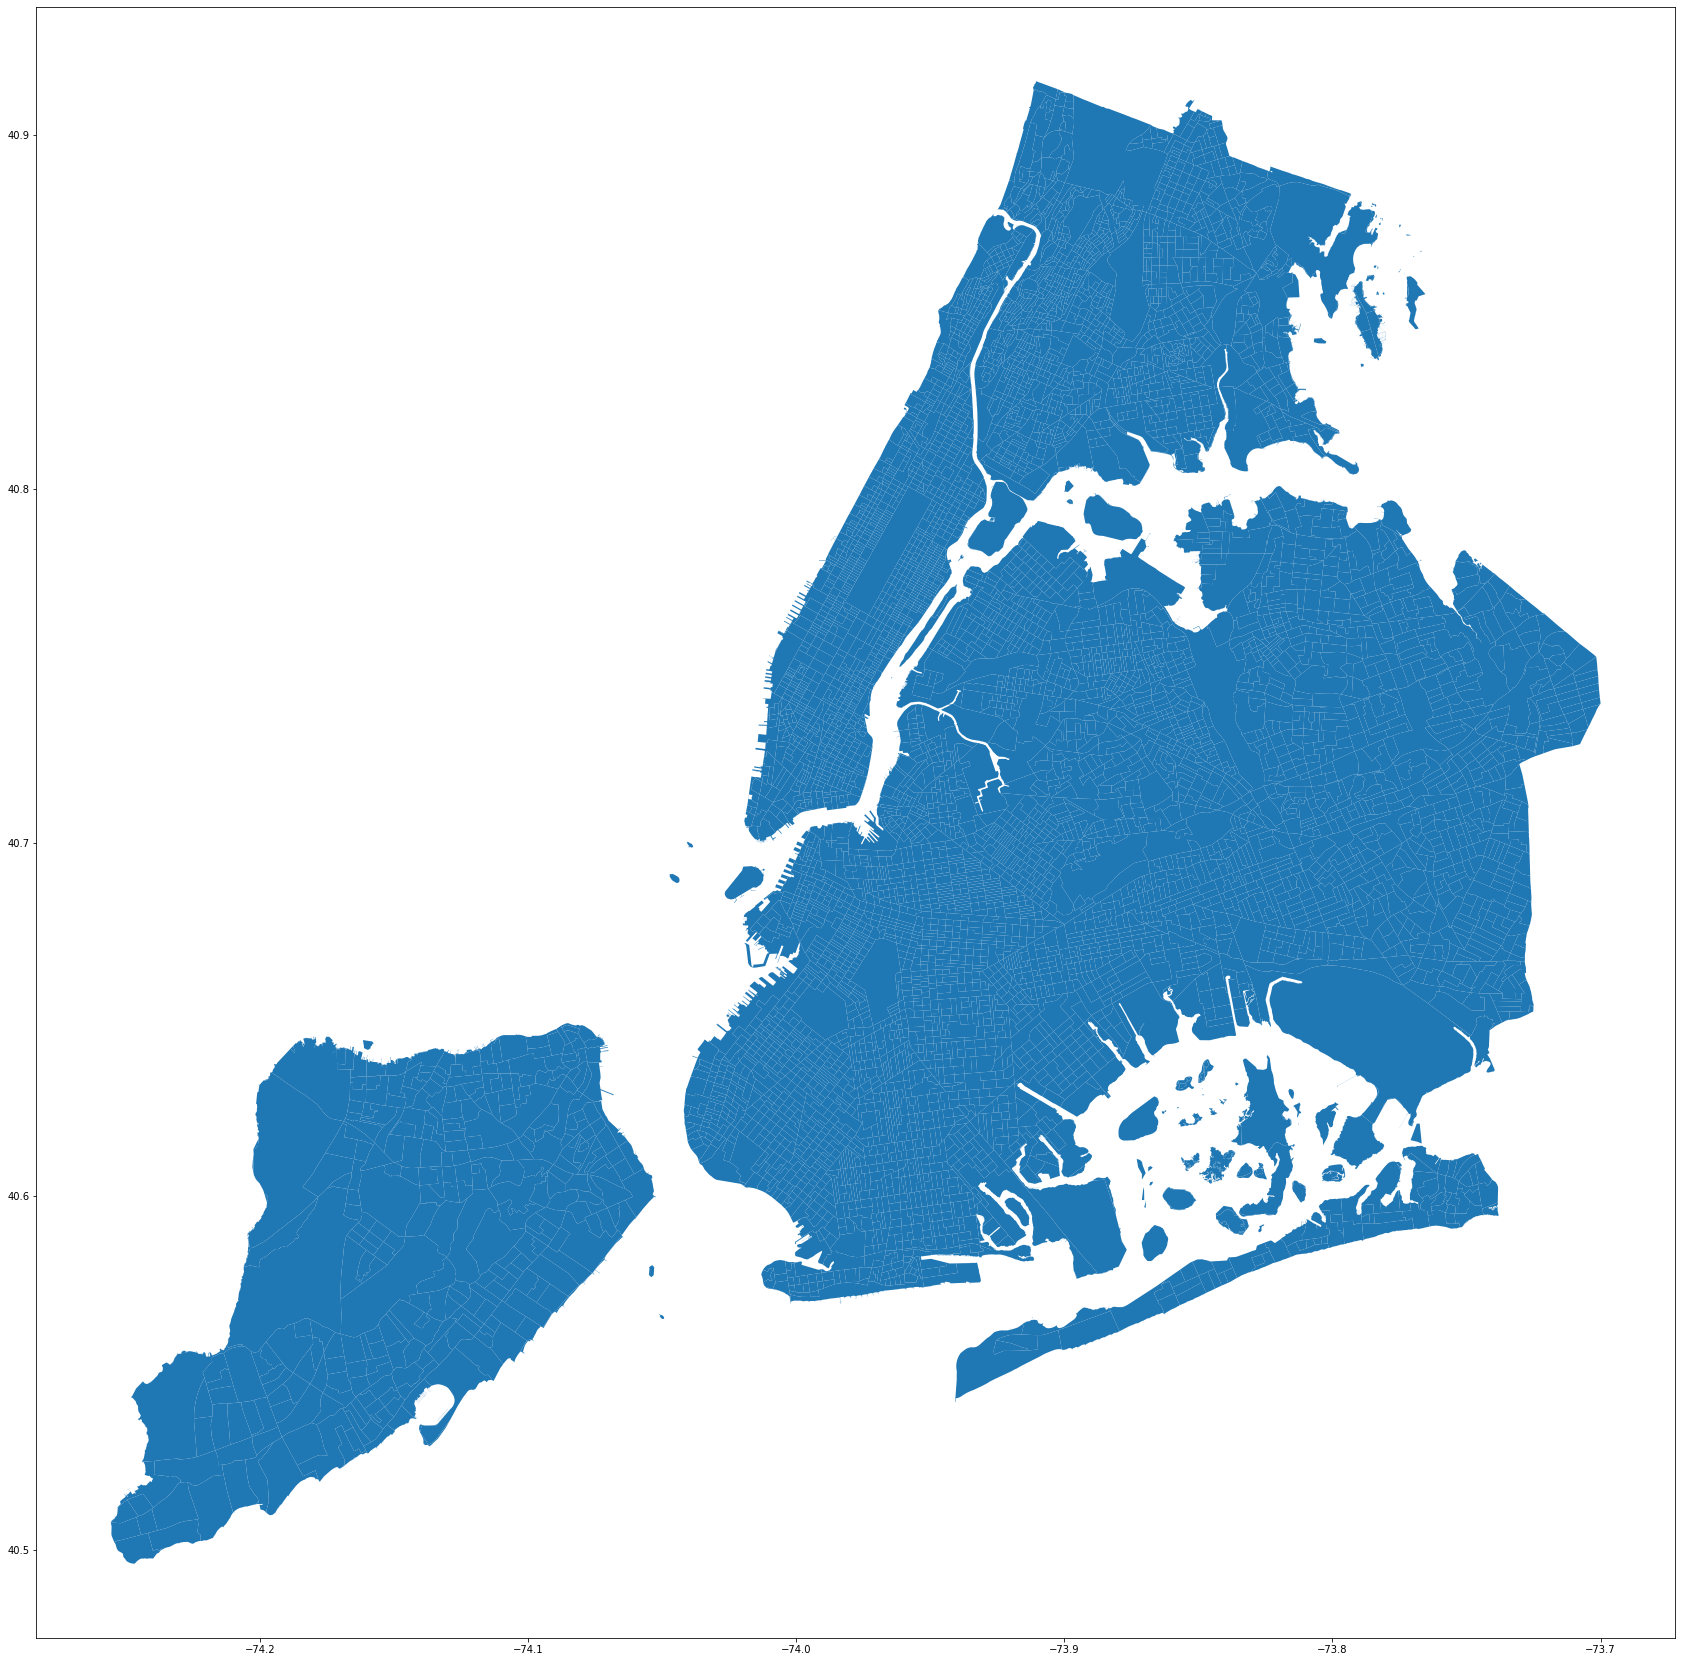

In [14]:
cb_gdf.plot(figsize=(30,30))

In [15]:
print(len(cb_gdf))

6493


In [16]:
# Slim down the dataset
sighting_cols = ['geometry', 'loc_type', 'year', 'month', 'day_of_week', 'time_range']
sightings_gdf[sighting_cols].head()

geometry     loc_type  year  month day_of_week time_range
0  POINT (-73.94675 40.81323)  Residential  2023  April   Wednesday    Evening
1  POINT (-73.94574 40.81281)  Residential  2023  April   Wednesday    Evening
2  POINT (-73.94159 40.65996)        Other  2023  April   Wednesday    Evening
3  POINT (-73.86086 40.82469)  Residential  2023  April     Tuesday    Evening
4  POINT (-73.94091 40.83649)  Residential  2023  April     Tuesday    Evening

In [17]:
# One hot encode the variables to columns

def encode_complaints(df, cols):
    # Encode
    loc_encoded = pd.get_dummies(df['loc_type'], prefix='l')
    dow_encoded = pd.get_dummies(df['day_of_week'], prefix='d')
    time_encoded = pd.get_dummies(df['time_range'], prefix='t')
    
    # Merge new variables
    sightings_merge = pd.merge(df[cols], loc_encoded, left_index=True, right_index=True)
    sightings_encoded_df = pd.merge(sightings_merge, dow_encoded, left_index=True, right_index=True)
    sightings_encoded_df = pd.merge(sightings_encoded_df, time_encoded, left_index=True, right_index=True)
    sightings_encoded_gdf = gpd.GeoDataFrame(sightings_encoded_df, geometry='geometry')

    return sightings_encoded_gdf

sightings_encoded_gdf = encode_complaints(sightings_gdf, sighting_cols)
sightings_encoded_gdf.head(5)

geometry     loc_type  year  month day_of_week  \
0  POINT (-73.94675 40.81323)  Residential  2023  April   Wednesday   
1  POINT (-73.94574 40.81281)  Residential  2023  April   Wednesday   
2  POINT (-73.94159 40.65996)        Other  2023  April   Wednesday   
3  POINT (-73.86086 40.82469)  Residential  2023  April     Tuesday   
4  POINT (-73.94091 40.83649)  Residential  2023  April     Tuesday   

  time_range  l_Commercial  l_Other  l_Outdoor  l_Residential  \
0    Evening             0        0          0              1   
1    Evening             0        0          0              1   
2    Evening             0        1          0              0   
3    Evening             0        0          0              1   
4    Evening             0        0          0              1   

   l_Residential-Mixed  l_Vacant_Space  d_Friday  d_Monday  d_Saturday  \
0                    0               0         0         0           0   
1                    0               0         0         0           0   
2                    0               0         0         0           0   
3                    0               0         0         0           0   
4                    0               0         0         0           0   

   d_Sunday  d_Thursday  d_Tuesday  d_Wednesday  t_Evening  t_Midday  \
0         0           0          0            1          1         0   
1         0           0          0            1          1         0   
2         0           0          0            1          1         0   
3         0           0          1            0          1         0   
4         0           0          1            0          1         0   

   t_Morning  
0          0  
1          0  
2          0  
3          0  
4          0

In [18]:
# Perform spatial join
sightings_joined_tracts_gdf = gpd.sjoin(sightings_encoded_gdf, cb_gdf[['geometry','spatial_id']], op='within', how='left')

def aggregate_sightings(df):
    # Aggregate the complaints
    loc_columns = [col for col in df.columns if col.startswith('l_')]
    dow_columns = [col for col in df.columns if col.startswith('d_')]
    time_columns = [col for col in df.columns if col.startswith('t_')]
    agg_cols = loc_columns + dow_columns + time_columns
    sightings_agg_dict = {col: ['sum'] for col in agg_cols}
    sightings_agg_dict['year'] = 'count'
    sightings_agg_df = df.groupby(['spatial_id','year']).agg(sightings_agg_dict).reset_index()
    sightings_agg_df.columns = sightings_agg_df.columns.map('_'.join)
    sightings_agg_df = sightings_agg_df.rename(columns={'year_count': 'num_sightings',
                                                        'year_':'year',
                                                        'spatial_id_':'spatial_id'})
    return sightings_agg_df
    

sightings_agg_df = aggregate_sightings(sightings_joined_tracts_gdf)
sightings_agg_df.head()


spatial_id  year  l_Commercial_sum  l_Other_sum  l_Outdoor_sum  \
0  360050001001  2020                 2            0              0   
1  360050001001  2021                 0            1              0   
2  360050001001  2022                 0            1              0   
3  360050002001  2018                 0            2              0   
4  360050002001  2019                 0            0              0   

   l_Residential_sum  l_Residential-Mixed_sum  l_Vacant_Space_sum  \
0                  0                        0                   0   
1                  0                        0                   0   
2                  0                        0                   0   
3                  3                        1                   0   
4                  4                        0                   0   

   d_Friday_sum  d_Monday_sum  d_Saturday_sum  d_Sunday_sum  d_Thursday_sum  \
0             0             1               0             0               1   
1             0             0               1             0               0   
2             0             1               0             0               0   
3             2             0               1             0               1   
4             1             1               0             0               1   

   d_Tuesday_sum  d_Wednesday_sum  t_Evening_sum  t_Midday_sum  t_Morning_sum  \
0              0                0              0             2              0   
1              0                0              0             1              0   
2              0                0              1             0              0   
3              2                0              6             0              0   
4              1                0              3             1              0   

   num_sightings  
0              2  
1              1  
2              1  
3              6  
4              4

In [19]:
# Duplicate the census blocks per years in dataset 
years = sightings_agg_df.year.unique()

years_cb_gdf = pd.DataFrame() # empty dataframe

for year in years:
    year_cb_gdf = cb_gdf.copy()
    year_cb_gdf['year'] = year
    years_cb_gdf = pd.concat([years_cb_gdf, year_cb_gdf])

print(len(years_cb_gdf))

years_cb_gdf.head(5)


38958


spatial_id                         name  %OfOwnerOccupiedHousing  \
0  360050001000  BG0001000, Bronx County, NY                   0.0000   
1  360050001001  BG0001001, Bronx County, NY                   0.0000   
2  360050002000  BG0002000, Bronx County, NY                   0.0000   
3  360050002001  BG0002001, Bronx County, NY                  48.0435   
4  360050002002  BG0002002, Bronx County, NY                  30.8962   

   %OfRenterOccupiedHousing  MedianHouseholdIncome  TotalPopulation  \
0                    0.0000                    NaN              0.0   
1                    0.0000                    NaN           6472.0   
2                    0.0000                    NaN              0.0   
3                   51.7391           40196.019522           1816.0   
4                   68.8679           47662.679687           1124.0   

                                            geometry  year  
0  MULTIPOLYGON (((-73.89679 40.79616, -73.89681 ...  2020  
1  POLYGON ((-73.89076 40.79782, -73.89076 40.797...  2020  
2  MULTIPOLYGON (((-73.86163 40.80990, -73.86111 ...  2020  
3  POLYGON ((-73.86240 40.81491, -73.86148 40.815...  2020  
4  MULTIPOLYGON (((-73.86425 40.81466, -73.86333 ...  2020

In [20]:
# Merge back to the census tracts 
sightings_gdf = pd.merge(years_cb_gdf, sightings_agg_df, on=['spatial_id','year'], how='left')

column_list = sightings_gdf.columns[8:]
sightings_gdf[column_list] = sightings_gdf[column_list].fillna(0)
sightings_gdf.head()

spatial_id                         name  %OfOwnerOccupiedHousing  \
0  360050001000  BG0001000, Bronx County, NY                   0.0000   
1  360050001001  BG0001001, Bronx County, NY                   0.0000   
2  360050002000  BG0002000, Bronx County, NY                   0.0000   
3  360050002001  BG0002001, Bronx County, NY                  48.0435   
4  360050002002  BG0002002, Bronx County, NY                  30.8962   

   %OfRenterOccupiedHousing  MedianHouseholdIncome  TotalPopulation  \
0                    0.0000                    NaN              0.0   
1                    0.0000                    NaN           6472.0   
2                    0.0000                    NaN              0.0   
3                   51.7391           40196.019522           1816.0   
4                   68.8679           47662.679687           1124.0   

                                            geometry  year  l_Commercial_sum  \
0  MULTIPOLYGON (((-73.89679 40.79616, -73.89681 ...  2020               0.0   
1  POLYGON ((-73.89076 40.79782, -73.89076 40.797...  2020               2.0   
2  MULTIPOLYGON (((-73.86163 40.80990, -73.86111 ...  2020               0.0   
3  POLYGON ((-73.86240 40.81491, -73.86148 40.815...  2020               0.0   
4  MULTIPOLYGON (((-73.86425 40.81466, -73.86333 ...  2020               1.0   

   l_Other_sum  l_Outdoor_sum  l_Residential_sum  l_Residential-Mixed_sum  \
0          0.0            0.0                0.0                      0.0   
1          0.0            0.0                0.0                      0.0   
2          0.0            0.0                0.0                      0.0   
3          0.0            0.0                0.0                      0.0   
4          0.0            0.0                0.0                      0.0   

   l_Vacant_Space_sum  d_Friday_sum  d_Monday_sum  d_Saturday_sum  \
0                 0.0           0.0           0.0             0.0   
1                 0.0           0.0           1.0             0.0   
2                 0.0           0.0           0.0             0.0   
3                 0.0           0.0           0.0             0.0   
4                 0.0           0.0           0.0             1.0   

   d_Sunday_sum  d_Thursday_sum  d_Tuesday_sum  d_Wednesday_sum  \
0           0.0             0.0            0.0              0.0   
1           0.0             1.0            0.0              0.0   
2           0.0             0.0            0.0              0.0   
3           0.0             0.0            0.0              0.0   
4           0.0             0.0            0.0              0.0   

   t_Evening_sum  t_Midday_sum  t_Morning_sum  num_sightings  
0            0.0           0.0            0.0            0.0  
1            0.0           2.0            0.0            2.0  
2            0.0           0.0            0.0            0.0  
3            0.0           0.0            0.0            0.0  
4            0.0           1.0            0.0            1.0

## Visualize Metrics 

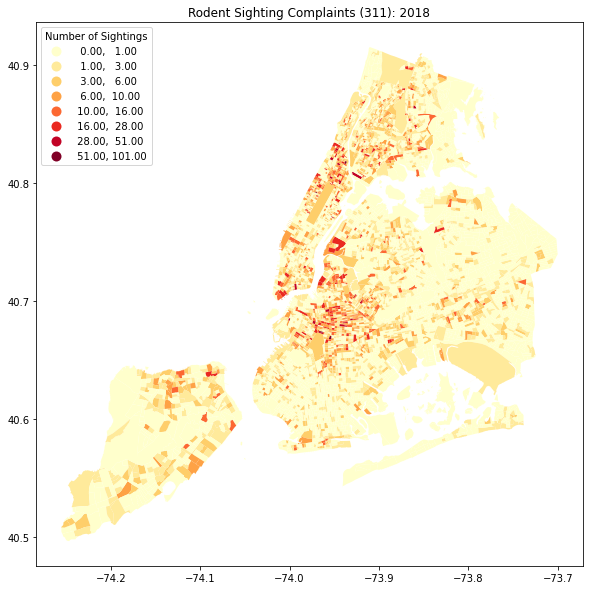

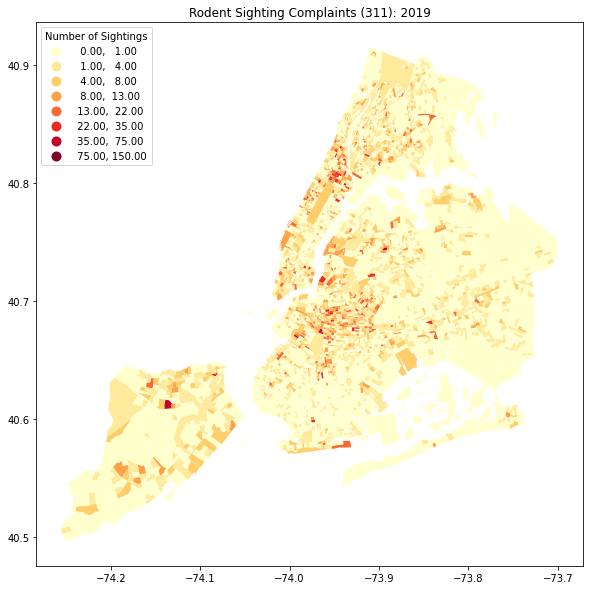

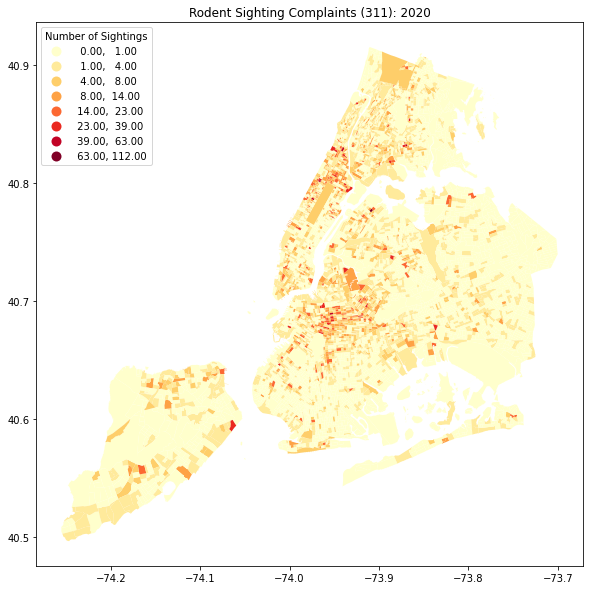

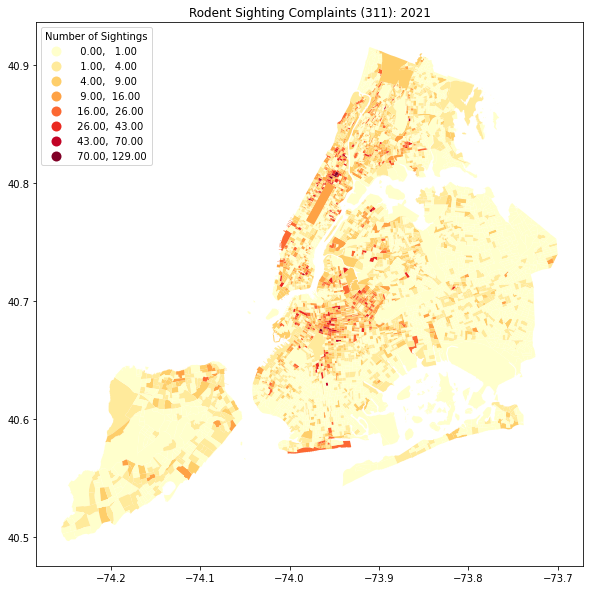

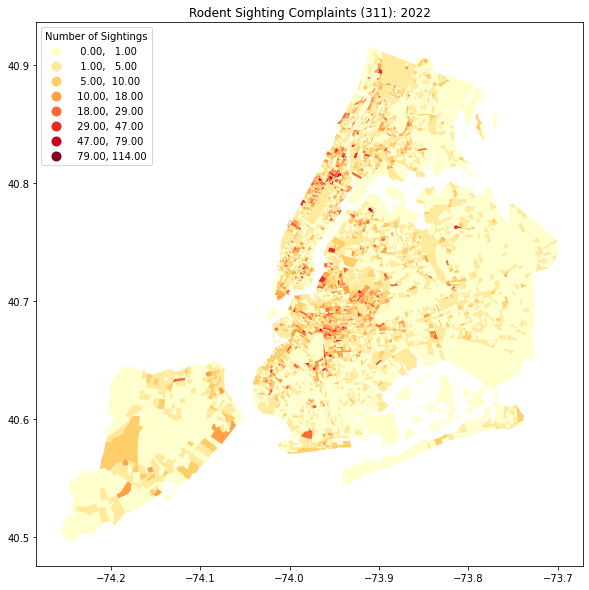

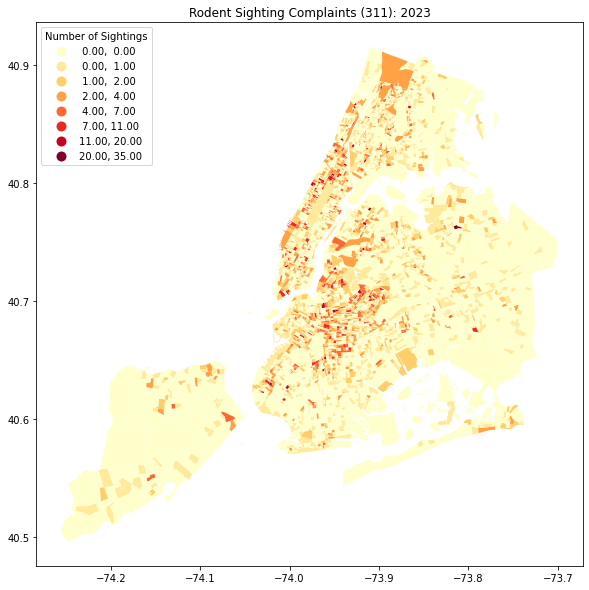

In [21]:
years = sorted(years)
for year in years:
    sightings_annual_gdf = sightings_gdf[(sightings_gdf['year']==year)]
    # Natural Breaks (Jenks)
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    sightings_annual_gdf.plot(column='num_sightings',
                        ax=ax,
                        cmap='YlOrRd',
                        scheme='natural_breaks',
                        k=8,
                        legend=True,
                        missing_kwds={'color': 'lightgray'},
                        legend_kwds={'loc': 'upper left', 'title': 'Number of Sightings'})
    plt.title('Rodent Sighting Complaints (311): {0}'.format(year))
    plt.show()

## Plot variables for one year (2021)

In [22]:
sightings_slim_gdf = sightings_gdf[(sightings_gdf['year']=='2021')]
sightings_slim_gdf.sort_values(by='num_sightings', ascending=False).head(5)

spatial_id                            name  %OfOwnerOccupiedHousing  \
10660  360610218004  BG0218004, New York County, NY                   0.6218   
10666  360610220001  BG0220001, New York County, NY                  18.7342   
10674  360610222002  BG0222002, New York County, NY                  12.7397   
8120   360470207001     BG0207001, Kings County, NY                  27.3455   
8475   360470333003     BG0333003, Kings County, NY                  30.9577   

       %OfRenterOccupiedHousing  MedianHouseholdIncome  TotalPopulation  \
10660                   99.2746           66817.200000           1786.0   
10666                   81.0127           71737.625589           1069.0   
10674                   87.1233           58185.513251           1838.0   
8120                    72.5400          124171.175835           1770.0   
8475                    68.8196           43202.235699           1817.0   

                                                geometry  year  \
10660  POLYGON ((-73.95442 40.80572, -73.95276 40.805...  2021   
10666  POLYGON ((-73.94974 40.80704, -73.94690 40.805...  2021   
10674  POLYGON ((-73.94882 40.80829, -73.94833 40.808...  2021   
8120   POLYGON ((-73.96630 40.67618, -73.96333 40.675...  2021   
8475   POLYGON ((-73.94804 40.66648, -73.94798 40.667...  2021   

       l_Commercial_sum  l_Other_sum  l_Outdoor_sum  l_Residential_sum  \
10660               1.0         24.0            0.0               21.0   
10666              23.0         38.0           15.0               25.0   
10674               2.0         50.0            1.0               38.0   
8120                0.0         22.0            0.0               76.0   
8475                0.0          1.0            0.0               66.0   

       l_Residential-Mixed_sum  l_Vacant_Space_sum  d_Friday_sum  \
10660                     77.0                 6.0          17.0   
10666                      2.0                 9.0          13.0   
10674                      3.0                14.0          12.0   
8120                       3.0                 0.0          25.0   
8475                       3.0                 0.0          10.0   

       d_Monday_sum  d_Saturday_sum  d_Sunday_sum  d_Thursday_sum  \
10660          23.0            18.0          16.0            21.0   
10666          15.0            11.0          14.0            22.0   
10674          20.0             8.0          17.0            14.0   
8120           11.0             8.0           8.0            17.0   
8475           14.0             2.0           7.0            12.0   

       d_Tuesday_sum  d_Wednesday_sum  t_Evening_sum  t_Midday_sum  \
10660           19.0             15.0           64.0          29.0   
10666           24.0             13.0           59.0          52.0   
10674           18.0             19.0           50.0          58.0   
8120            12.0             20.0           64.0          32.0   
8475            12.0             13.0           27.0          36.0   

       t_Morning_sum  num_sightings  
10660           36.0          129.0  
10666            1.0          112.0  
10674            0.0          108.0  
8120             5.0          101.0  
8475             7.0           70.0

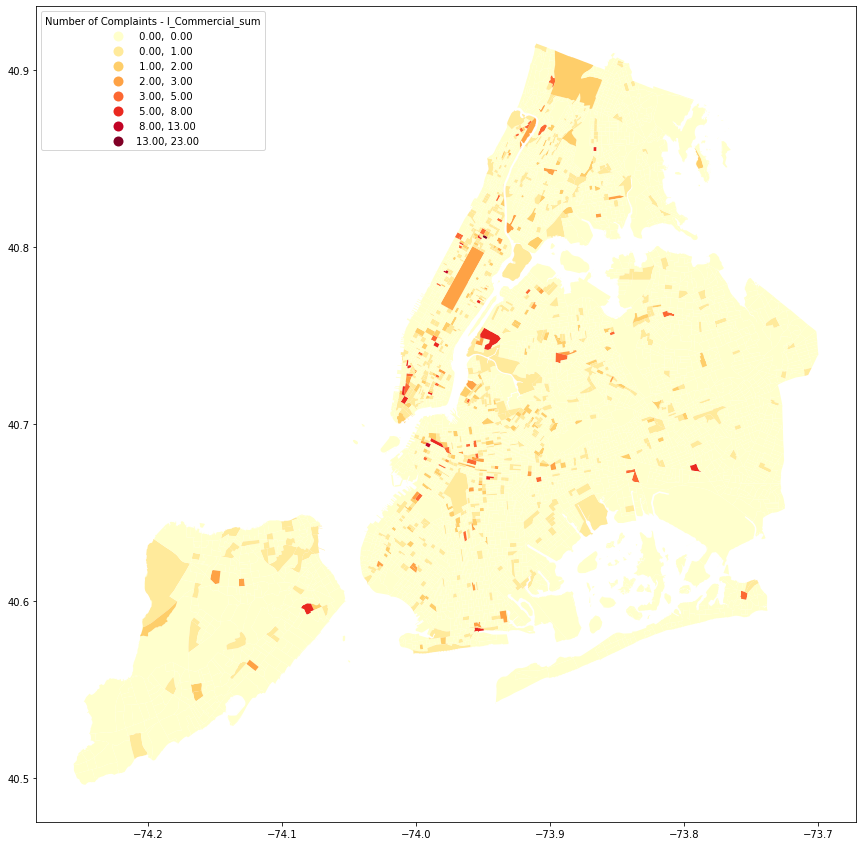

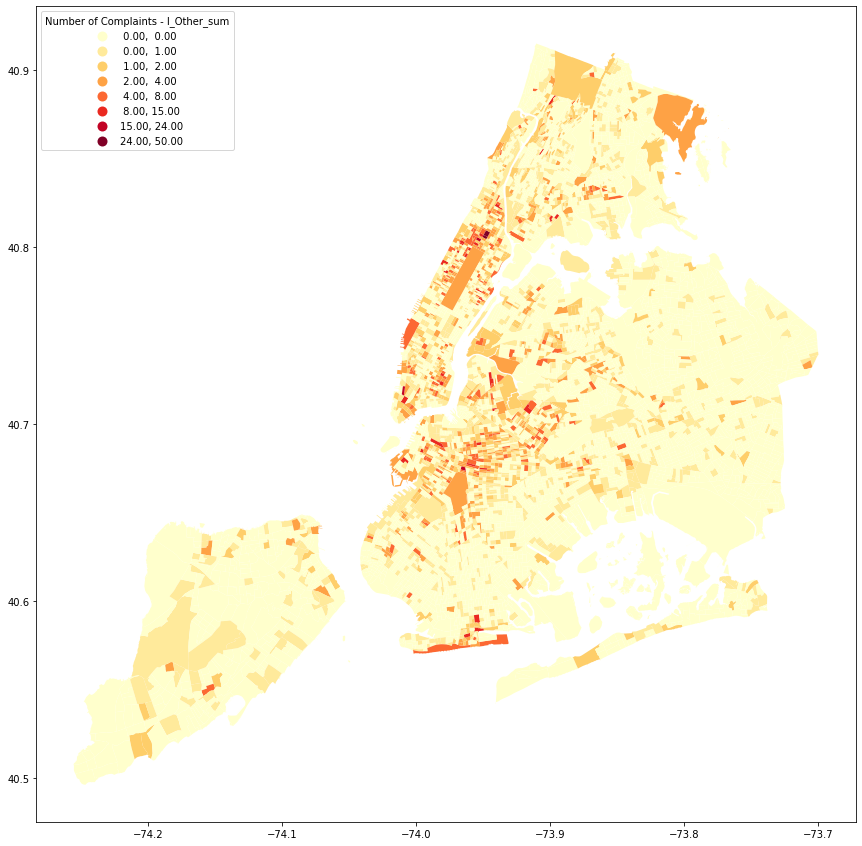

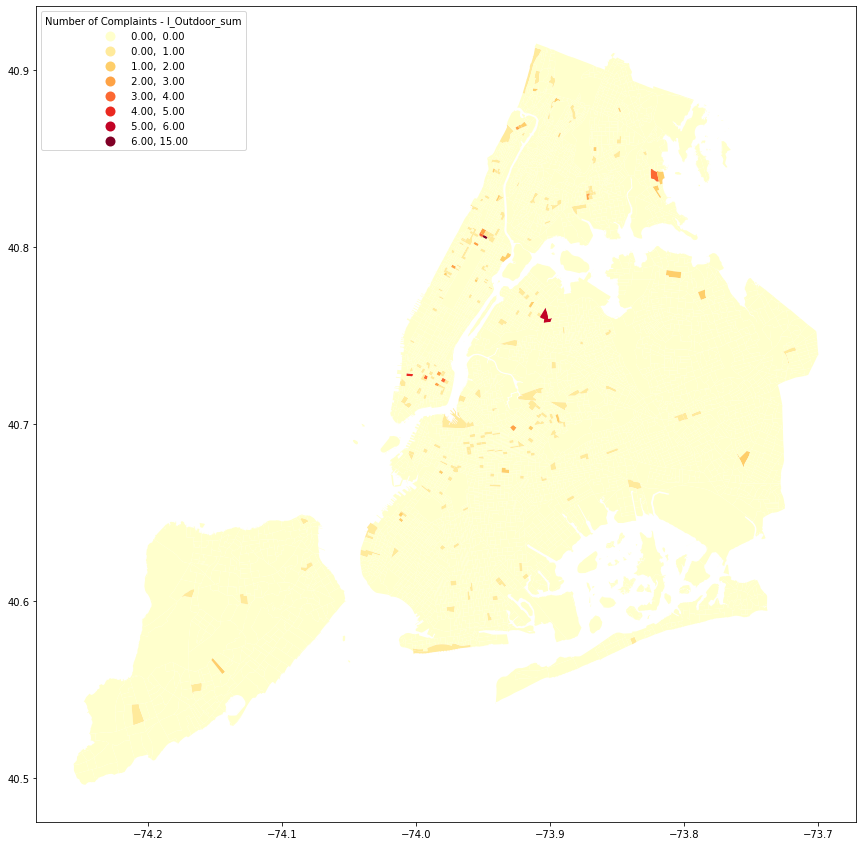

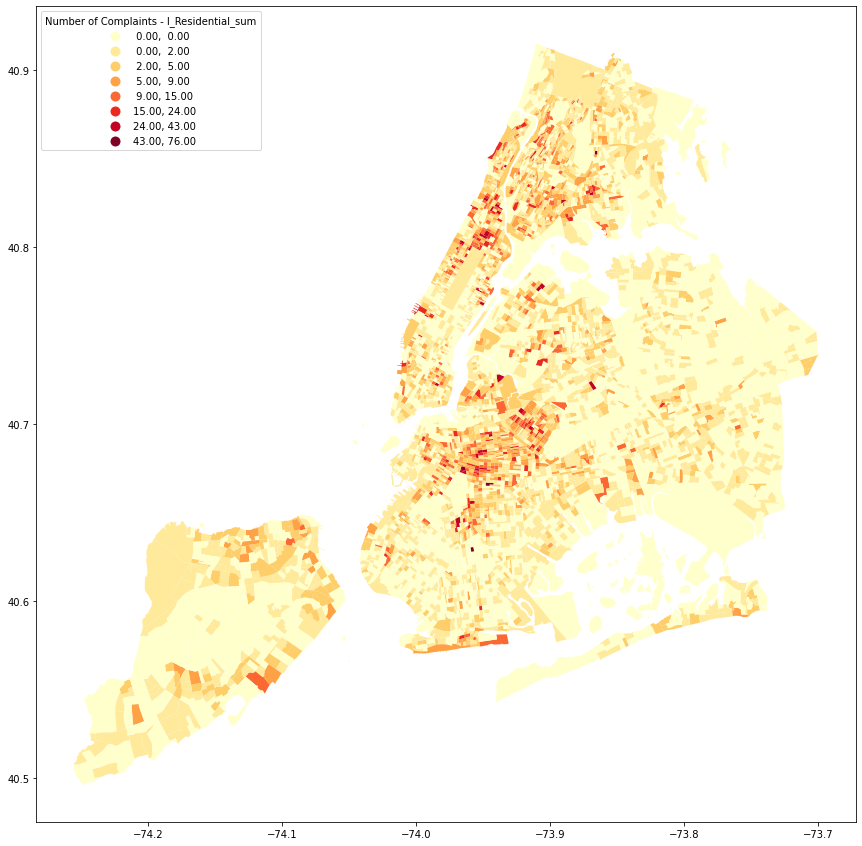

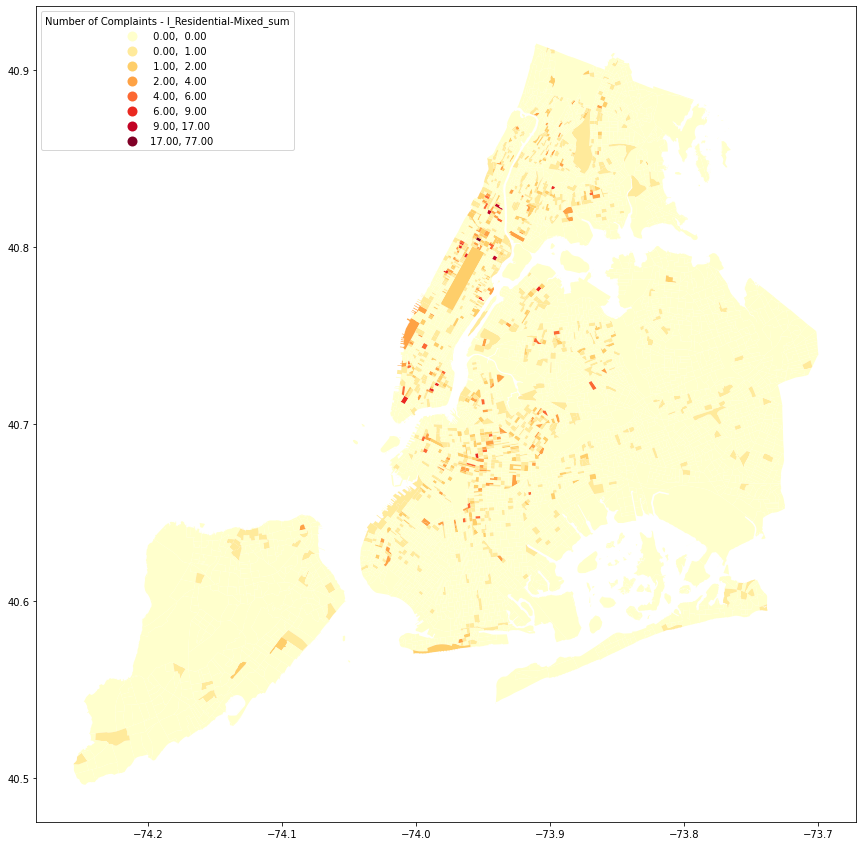

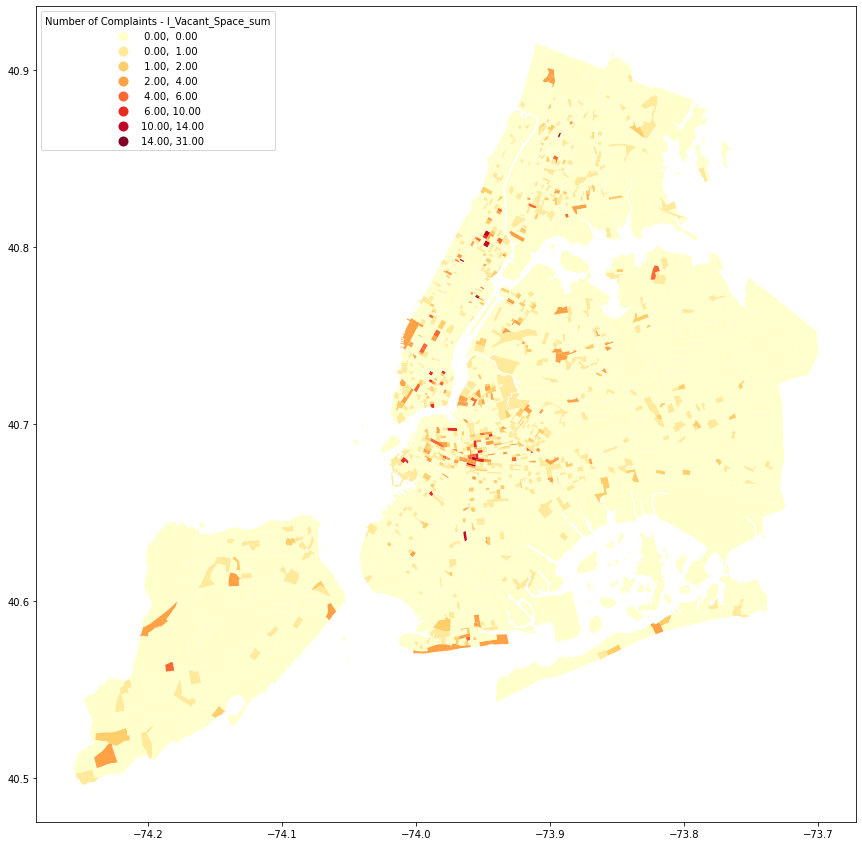

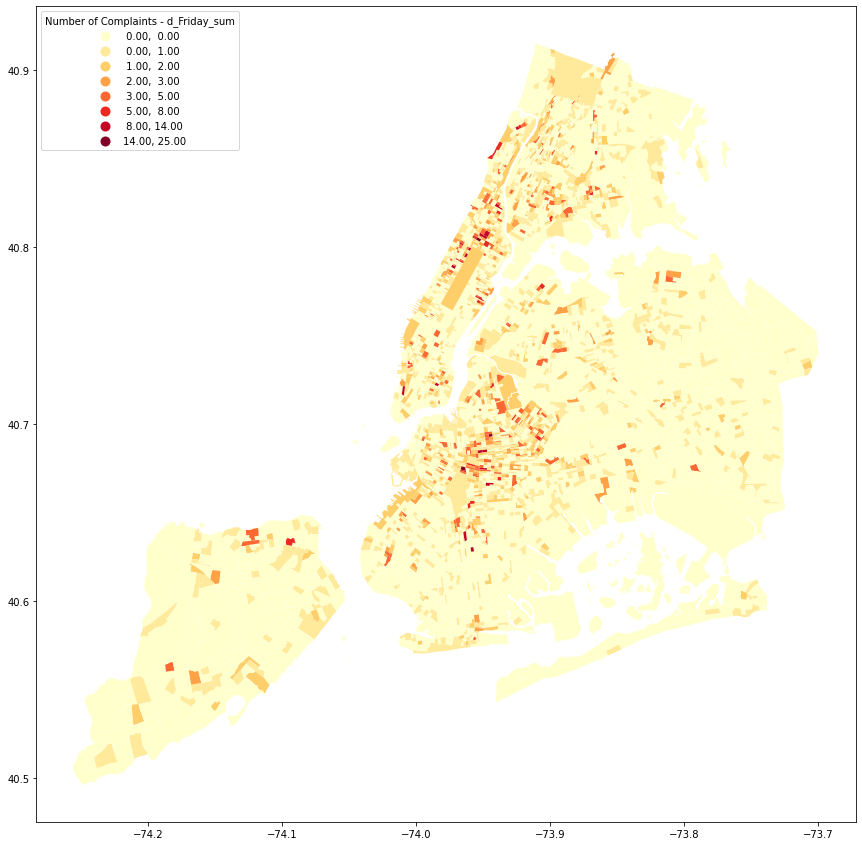

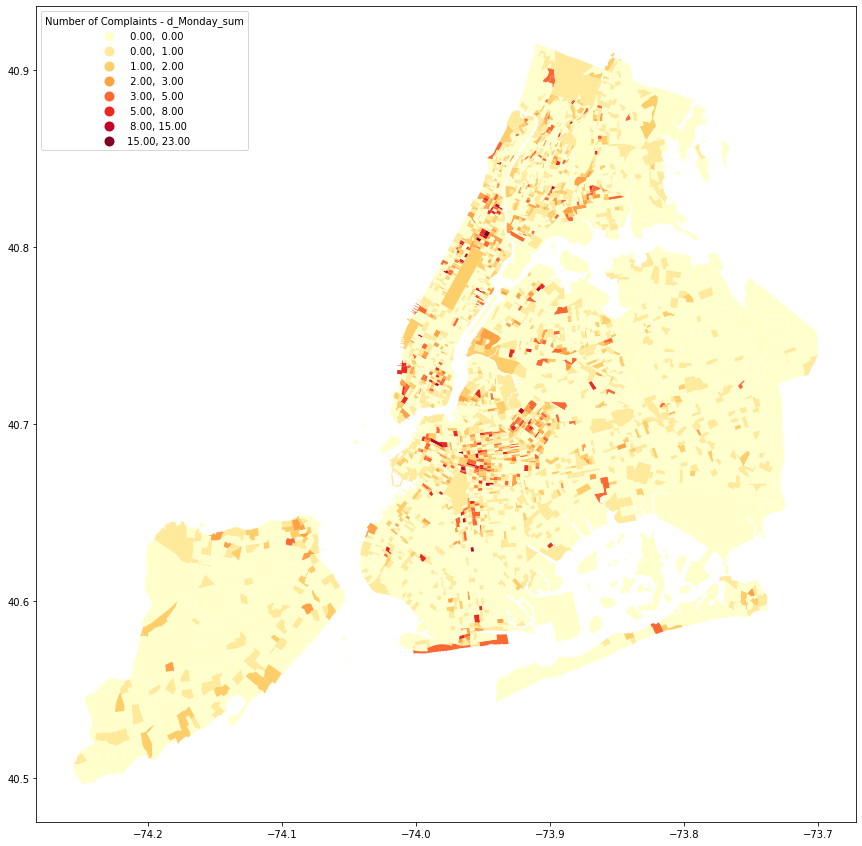

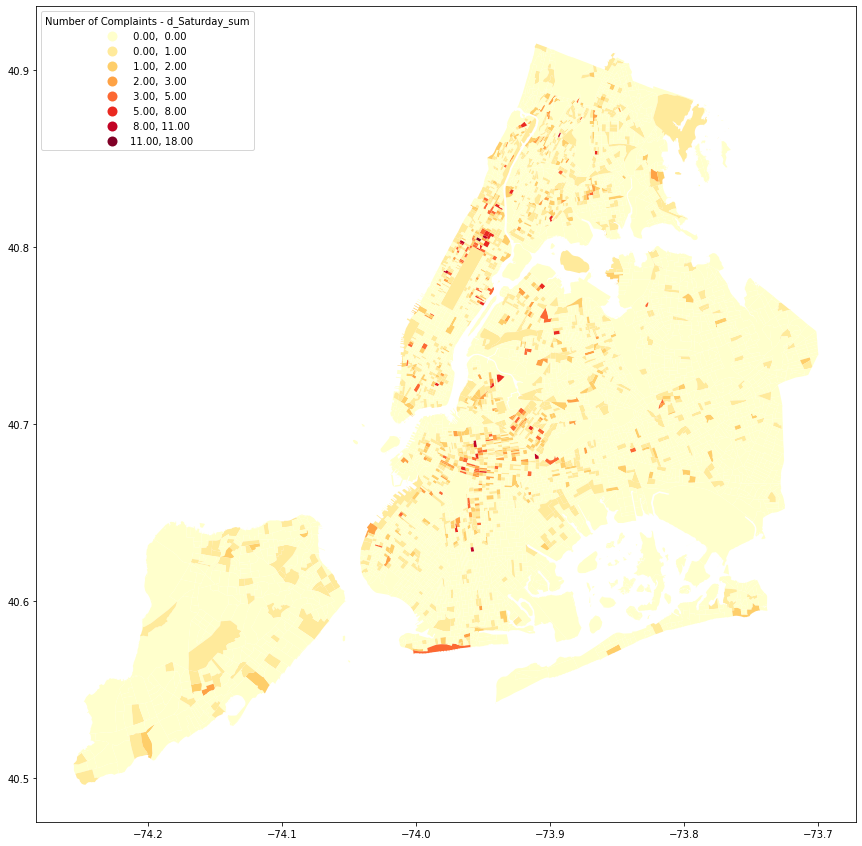

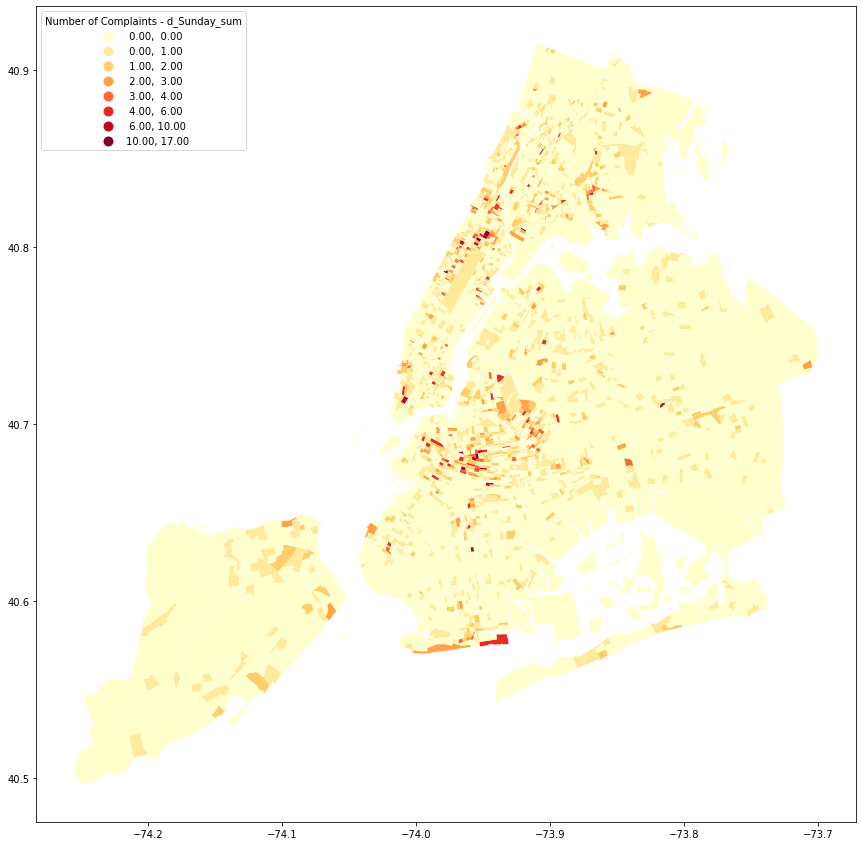

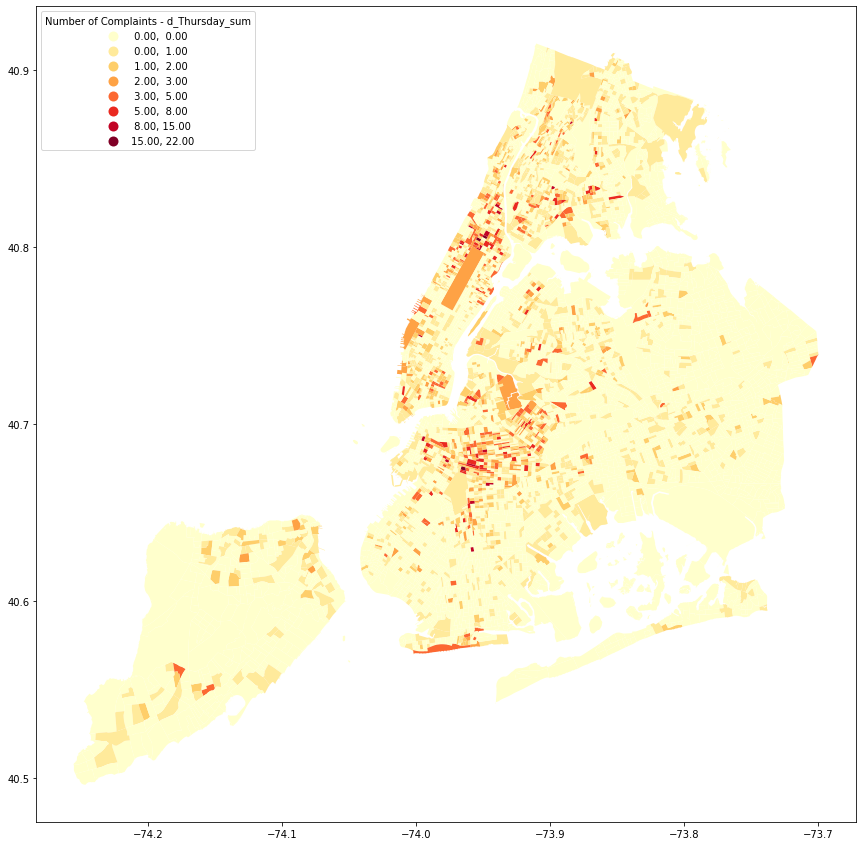

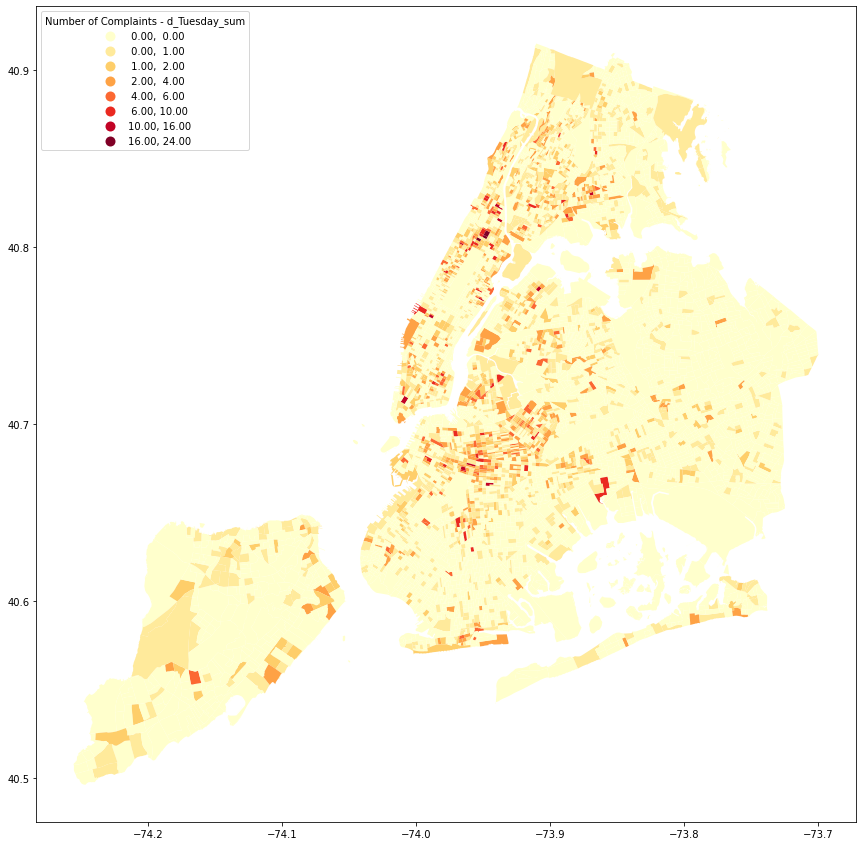

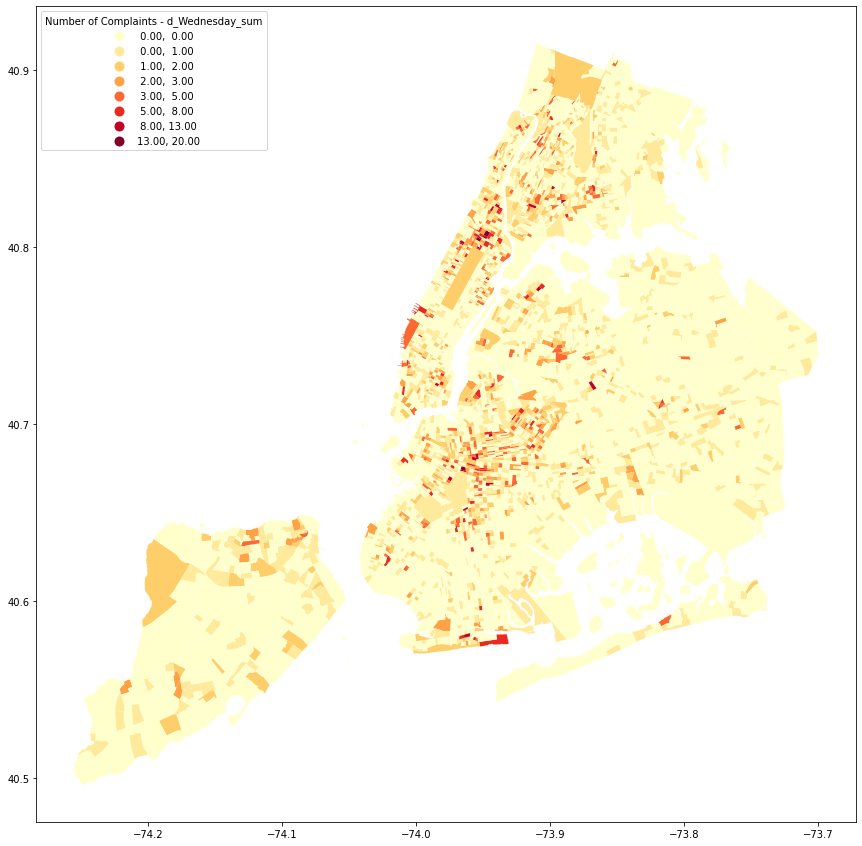

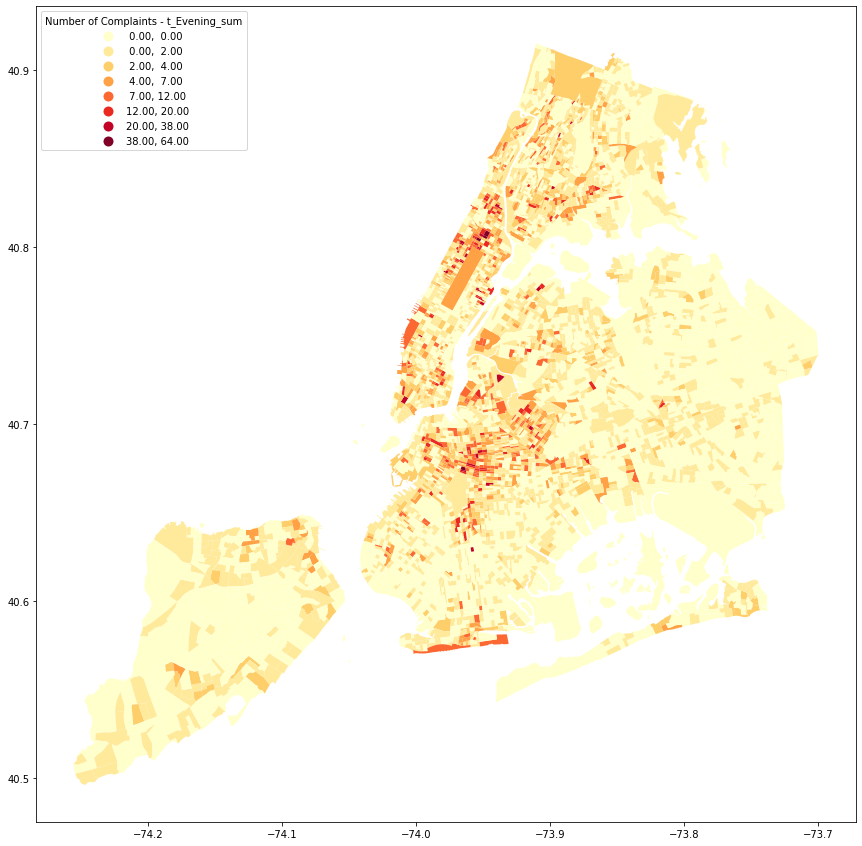

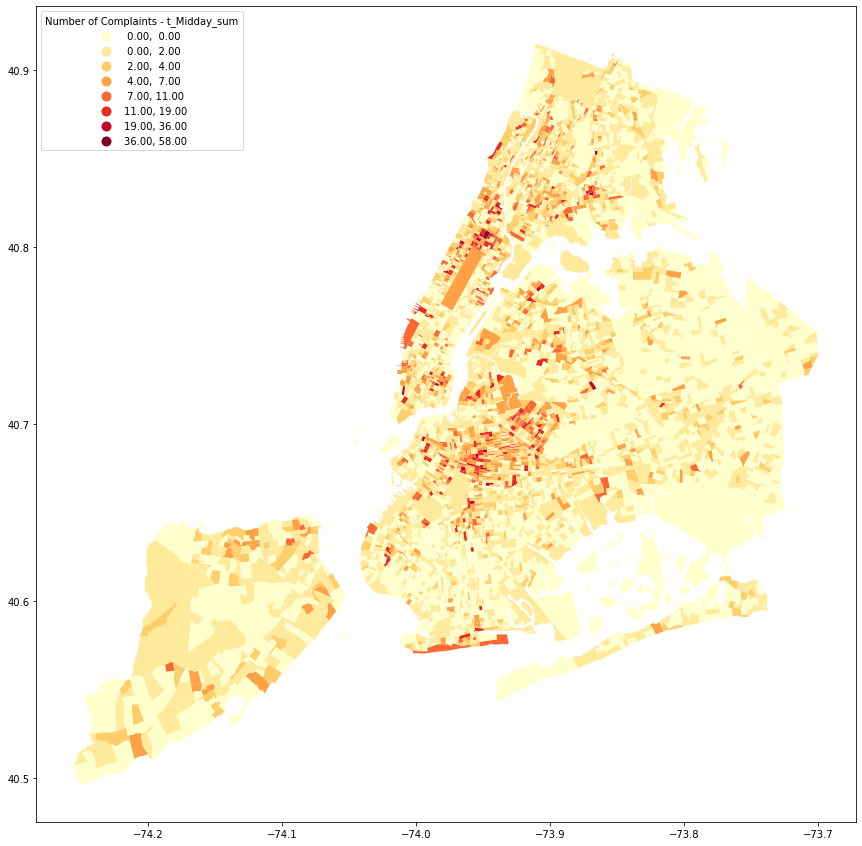

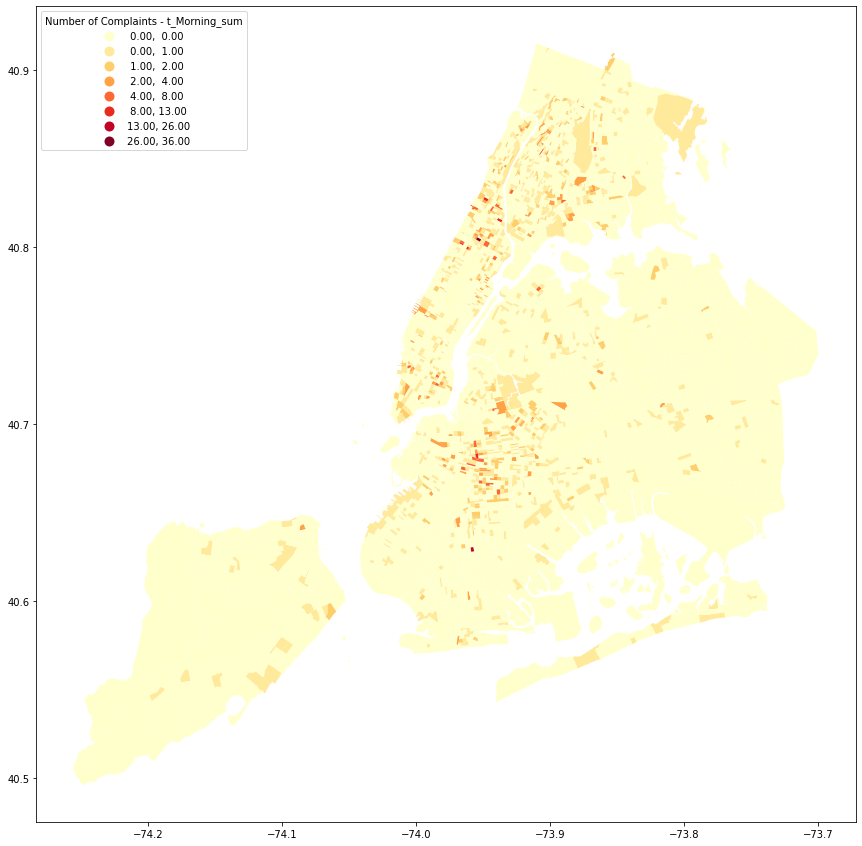

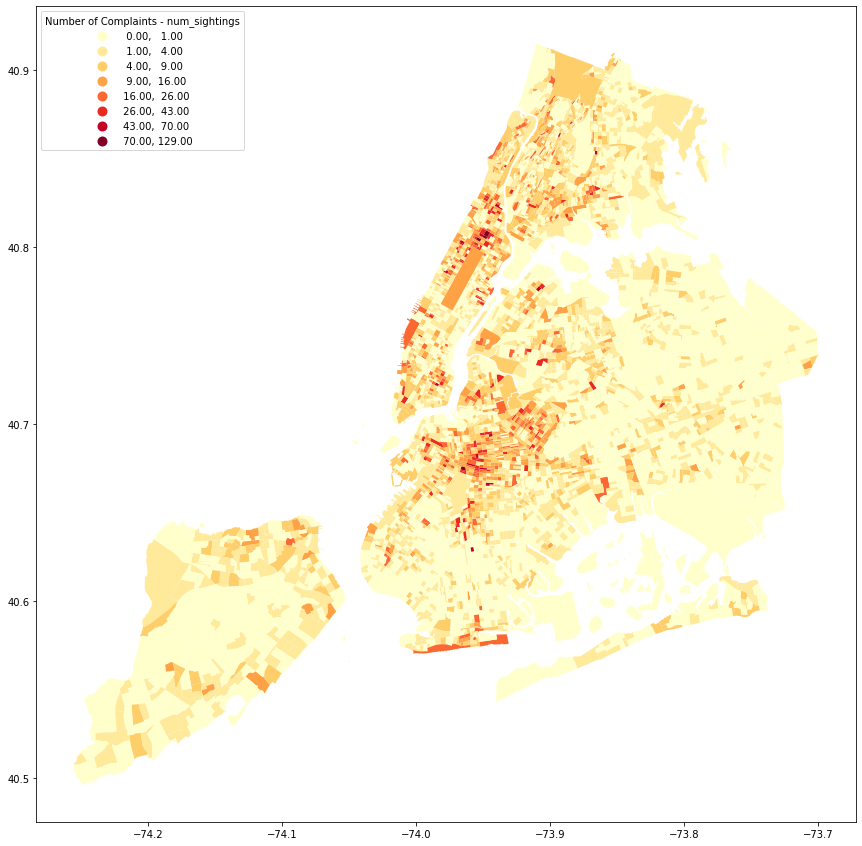

In [23]:
def plot_map(column_name, title):
    fig, ax = plt.subplots(1, 1, figsize=(15, 15))
    sightings_slim_gdf.plot(column=column_name,
                        ax=ax,
                        cmap='YlOrRd',
                        scheme='natural_breaks',
                        k=8,
                        legend=True,
                        missing_kwds={'color': 'lightgray'},
                        legend_kwds={'loc': 'upper left', 'title': title})
    plt.show()

for column in column_list:
    plot_title = f'Number of Complaints - {column}'
    plot_map(column, plot_title)

# Export to csv 

Not exporting to GeoJson because the dataset would be very large. Helper code below to load.

In [37]:
export_columns = ['spatial_id'] + sightings_gdf.columns[7:].to_list()
print(export_columns)
parent_dir = os.path.abspath('..')  # get the absolute path of the parent directory
file_path = os.path.join(parent_dir, 'Data', 'sightings_per_year.csv')  # construct the file path
sightings_gdf[export_columns].to_csv(file_path, index=False)

['spatial_id', 'year', 'l_Commercial_sum', 'l_Other_sum', 'l_Outdoor_sum', 'l_Residential_sum', 'l_Residential-Mixed_sum', 'l_Vacant_Space_sum', 'd_Friday_sum', 'd_Monday_sum', 'd_Saturday_sum', 'd_Sunday_sum', 'd_Thursday_sum', 'd_Tuesday_sum', 'd_Wednesday_sum', 't_Evening_sum', 't_Midday_sum', 't_Morning_sum', 'num_sightings']


### EXAMPLE 

In [42]:
parent_dir = os.path.abspath('..')  # get the absolute path of the parent directory

In [49]:
# Read Census Block Groups
cb_file_path = os.path.join(parent_dir, 'Data', 'nyc_bgrp.geojson')  # construct the file path
cb_gdf = gpd.read_file(cb_file_path)  # load the GeoJSON file into a GeoDataFrame
print(cb_gdf.dtypes)
print(len(cb_gdf))
cb_gdf.head(2)

spatial_id                    object
name                          object
%OfOwnerOccupiedHousing      float64
%OfRenterOccupiedHousing     float64
MedianHouseholdIncome        float64
TotalPopulation              float64
geometry                    geometry
dtype: object
6493


spatial_id                         name  %OfOwnerOccupiedHousing  \
0  360050001000  BG0001000, Bronx County, NY                      0.0   
1  360050001001  BG0001001, Bronx County, NY                      0.0   

   %OfRenterOccupiedHousing  MedianHouseholdIncome  TotalPopulation  \
0                       0.0                    NaN              0.0   
1                       0.0                    NaN           6472.0   

                                            geometry  
0  MULTIPOLYGON (((-73.89679 40.79616, -73.89681 ...  
1  POLYGON ((-73.89076 40.79782, -73.89076 40.797...

In [51]:
# Read Sightings
sightings_file_path = os.path.join(parent_dir, 'Data', 'sightings_per_year.csv')  # construct the file path
sightings_df = pd.read_csv(sightings_file_path)
sightings_df['spatial_id'] = sightings_df['spatial_id'].astype(str)
print(len(sightings_df))
print(sightings_df.dtypes)
sightings_df.head(2)

38958
spatial_id                  object
year                         int64
l_Commercial_sum           float64
l_Other_sum                float64
l_Outdoor_sum              float64
l_Residential_sum          float64
l_Residential-Mixed_sum    float64
l_Vacant_Space_sum         float64
d_Friday_sum               float64
d_Monday_sum               float64
d_Saturday_sum             float64
d_Sunday_sum               float64
d_Thursday_sum             float64
d_Tuesday_sum              float64
d_Wednesday_sum            float64
t_Evening_sum              float64
t_Midday_sum               float64
t_Morning_sum              float64
num_sightings              float64
dtype: object


spatial_id  year  l_Commercial_sum  l_Other_sum  l_Outdoor_sum  \
0  360050001000  2020               0.0          0.0            0.0   
1  360050001001  2020               2.0          0.0            0.0   

   l_Residential_sum  l_Residential-Mixed_sum  l_Vacant_Space_sum  \
0                0.0                      0.0                 0.0   
1                0.0                      0.0                 0.0   

   d_Friday_sum  d_Monday_sum  d_Saturday_sum  d_Sunday_sum  d_Thursday_sum  \
0           0.0           0.0             0.0           0.0             0.0   
1           0.0           1.0             0.0           0.0             1.0   

   d_Tuesday_sum  d_Wednesday_sum  t_Evening_sum  t_Midday_sum  t_Morning_sum  \
0            0.0              0.0            0.0           0.0            0.0   
1            0.0              0.0            0.0           2.0            0.0   

   num_sightings  
0            0.0  
1            2.0

In [52]:
sightings_gdf = pd.merge(cb_gdf, sightings_df, on=['spatial_id'], how='left')

print(len(sightings_gdf))
sightings_gdf.head(2)

38958


spatial_id                         name  %OfOwnerOccupiedHousing  \
0  360050001000  BG0001000, Bronx County, NY                      0.0   
1  360050001000  BG0001000, Bronx County, NY                      0.0   

   %OfRenterOccupiedHousing  MedianHouseholdIncome  TotalPopulation  \
0                       0.0                    NaN              0.0   
1                       0.0                    NaN              0.0   

                                            geometry  year  l_Commercial_sum  \
0  MULTIPOLYGON (((-73.89679 40.79616, -73.89681 ...  2020               0.0   
1  MULTIPOLYGON (((-73.89679 40.79616, -73.89681 ...  2021               0.0   

   l_Other_sum  l_Outdoor_sum  l_Residential_sum  l_Residential-Mixed_sum  \
0          0.0            0.0                0.0                      0.0   
1          0.0            0.0                0.0                      0.0   

   l_Vacant_Space_sum  d_Friday_sum  d_Monday_sum  d_Saturday_sum  \
0                 0.0           0.0           0.0             0.0   
1                 0.0           0.0           0.0             0.0   

   d_Sunday_sum  d_Thursday_sum  d_Tuesday_sum  d_Wednesday_sum  \
0           0.0             0.0            0.0              0.0   
1           0.0             0.0            0.0              0.0   

   t_Evening_sum  t_Midday_sum  t_Morning_sum  num_sightings  
0            0.0           0.0            0.0            0.0  
1            0.0           0.0            0.0            0.0